# Time-series Metrics 

Haytham Mohamed - INFS890 - Spring 2020

Using metrics as time-series data to predict future latency

In [381]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(color_codes=True)

In [382]:
file_dir = '../../data/processed-data/'
data_file = 'all_data.csv'

data_df = pd.read_csv(file_dir + data_file, header=None, skiprows=1, names=['metric', 'date', 'value'])

data_df.head(5)

,metric,date,value
0,svc_req_rate,2020-02-17 08:36:51,0.98
1,svc_req_rate,2020-02-17 08:37:06,1.62
2,svc_req_rate,2020-02-17 08:37:21,2.18
3,svc_req_rate,2020-02-17 08:37:36,2.13
4,svc_req_rate,2020-02-17 08:37:51,2.22


In [383]:
def extractMetricSeries(df, name):
    metric = df.loc[df['metric'] == name].drop(['metric'], axis=1).rename(index=str, columns={"value": name})
    metric.date = pd.to_datetime(metric.date)
    metric[name] = pd.to_numeric(metric[name])
    metric.set_index('date', inplace=True)
    metric.sort_index()
    return metric

# T for minutes, S for seconds
def resample(df, frequency = '15S', interpolate = True, interpolate_method = 'linear', base=6):
    # fill in missing interval (upsample)
    resampled = df.resample(frequency, kind='timestamp', base=base).bfill()
    if interpolate:
        resampled = resampled.interpolate(method=interpolate_method)
    return resampled

def plotSeries(df):
    df.plot(figsize=(20,10), linewidth=2, fontsize=20)
    plt.xlabel('Time', fontsize=20);
    plt.show()
    
def diffSeries(df):
    # eliminate seasonality, taking first diff
    return df.diff()        

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).bfill()    
    

In [384]:
target = 'svc_ltcy_200'

print("Processing metric: %", target)
metrics_df = extractMetricSeries(df, target)
metrics_df = resample(metrics_df, interpolate=False)
#metrics_df = diffSeries(metrics_df)


metrics_df.shape

Processing metric: % svc_ltcy_200


(19722, 1)

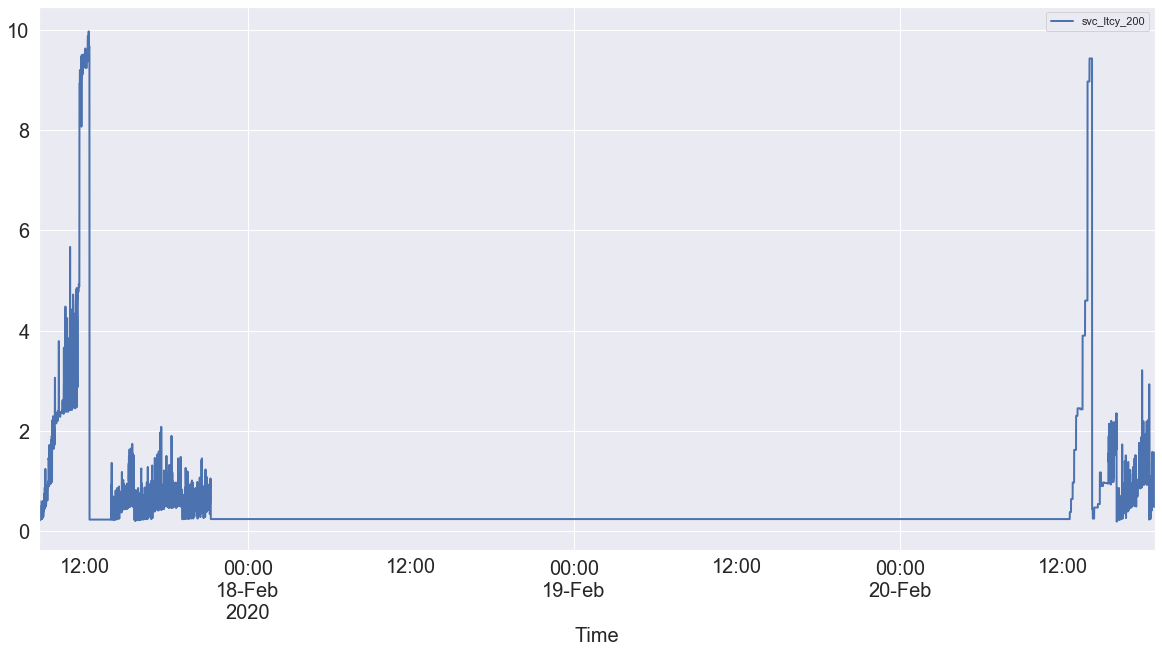

In [385]:
plotSeries(metrics_df)

Processing metric: % svc_req_rate
Processing metric: % svc_cpu_use
Processing metric: % svc_cpu_sat
Processing metric: % svc_net_use
Processing metric: % svc_disk_use
Processing metric: % system_cpu_use
Processing metric: % system_cpu_sat
Processing metric: % system_net_use
Processing metric: % system_net_sat
Processing metric: % system_disk_sat
Processing metric: % system_disk_io
Processing metric: % svc_req_size
Processing metric: % svc_resp_size
Processing metric: % svc_pods


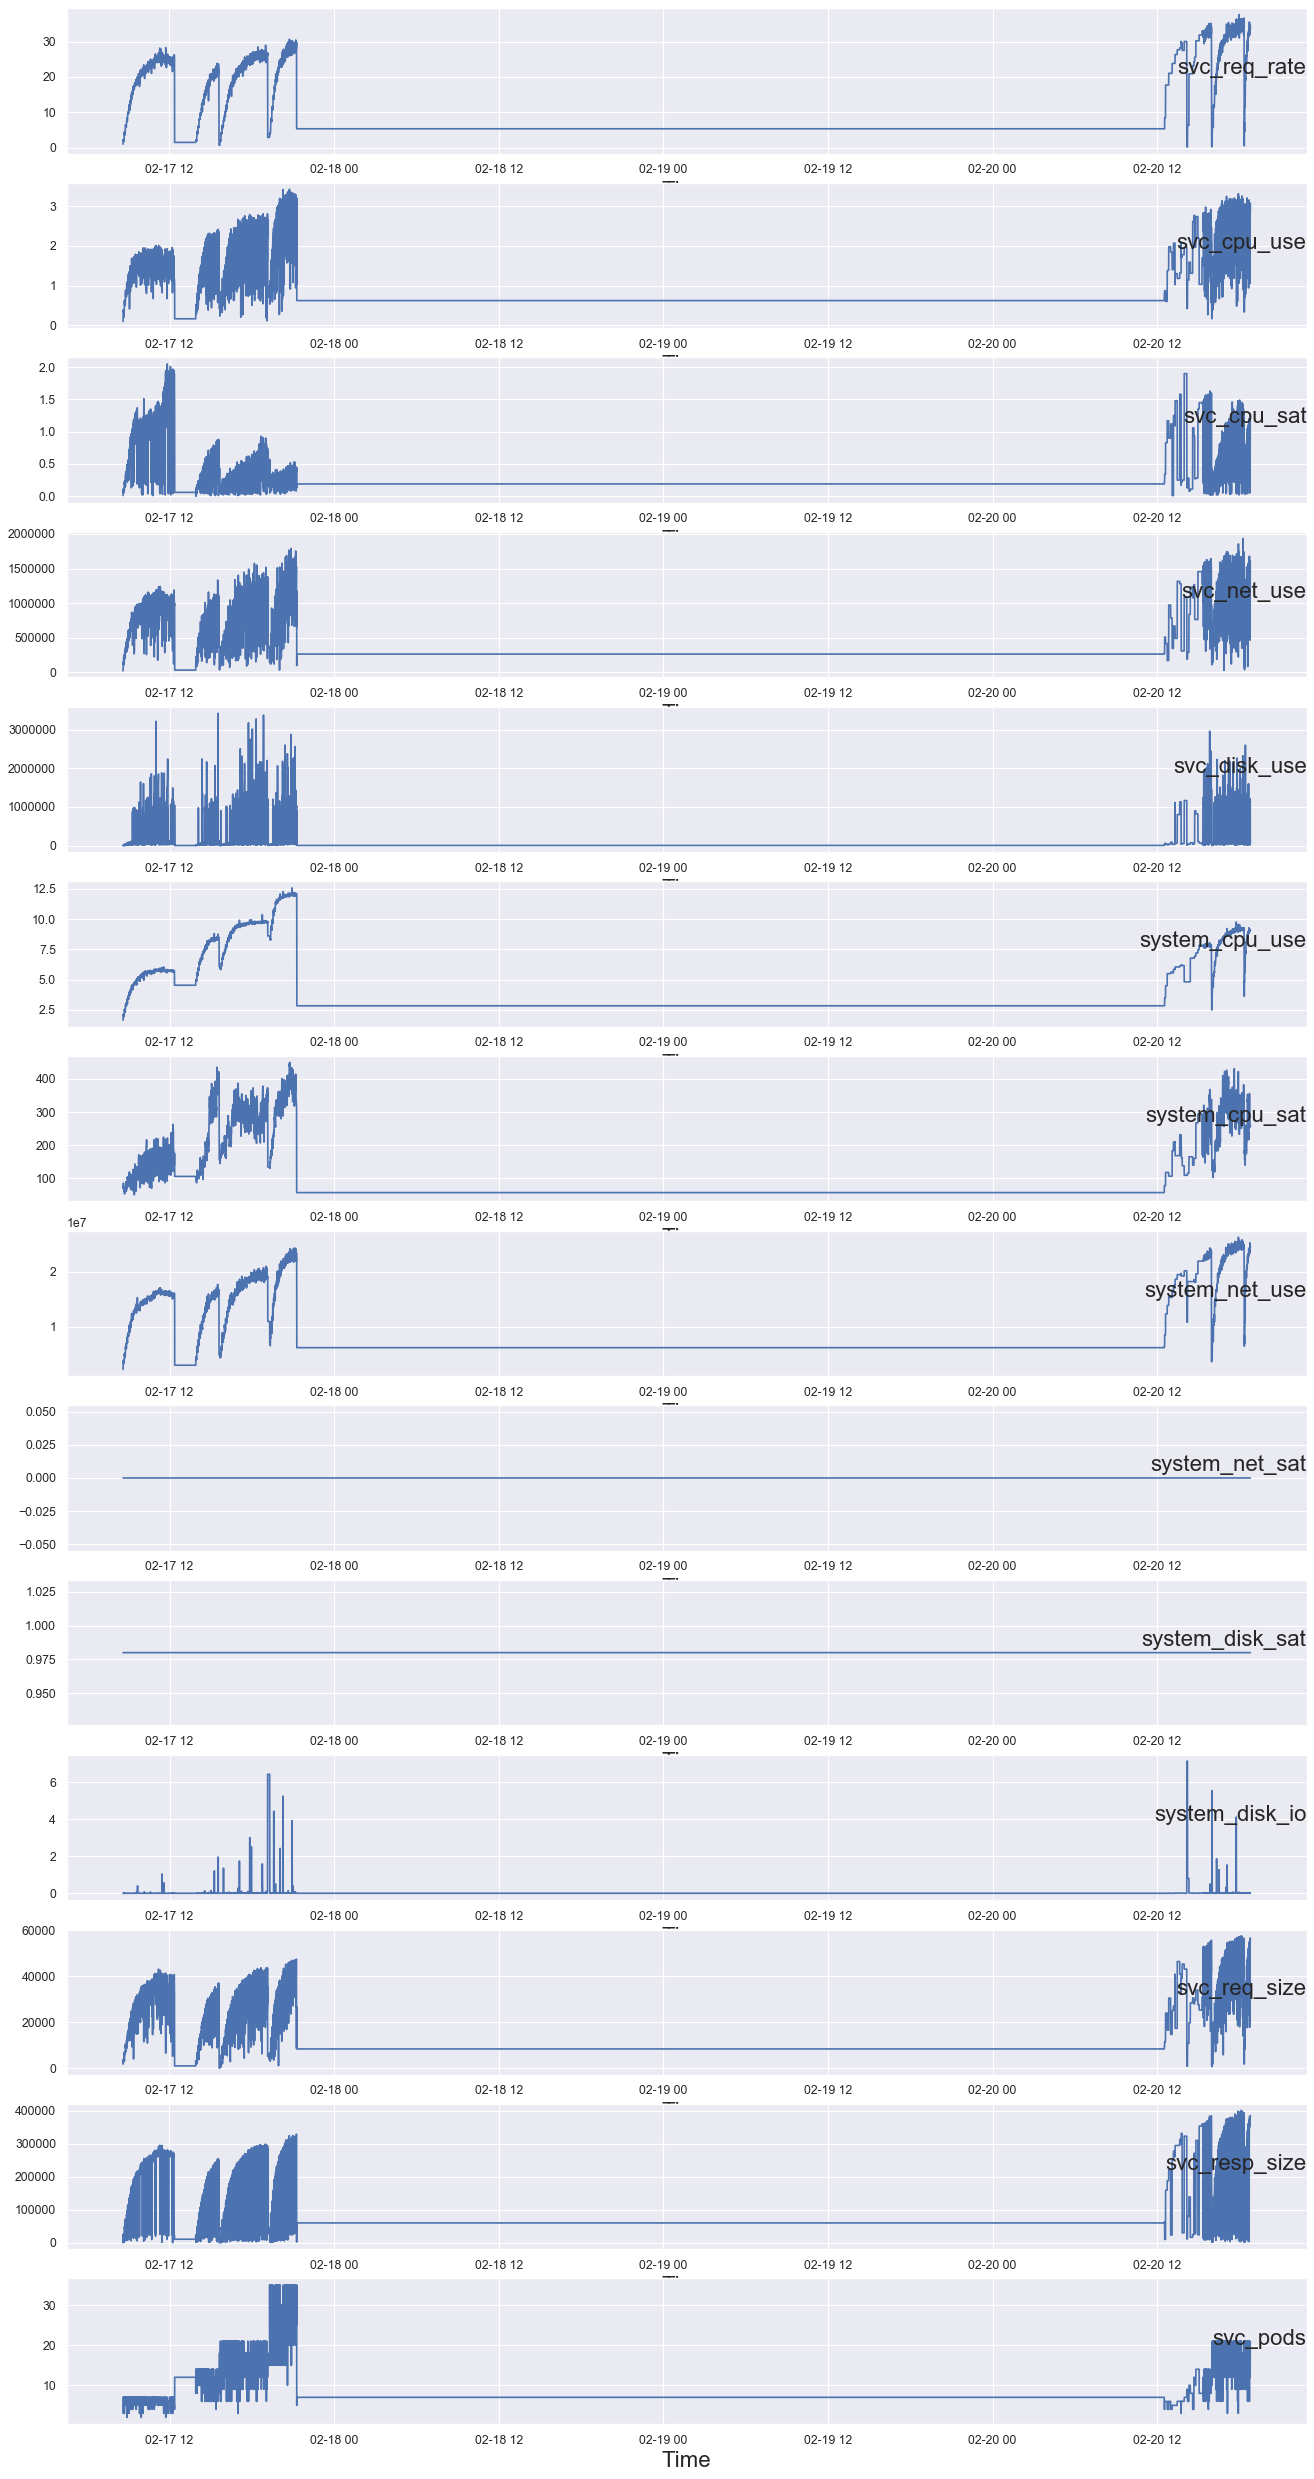

In [386]:
features = ['svc_req_rate', 'svc_cpu_use', 'svc_cpu_sat', 'svc_net_use', 'svc_disk_use'
           , 'system_cpu_use', 'system_cpu_sat', 'system_net_use', 'system_net_sat', 'system_disk_sat'
           , 'system_disk_io', 'svc_req_size', 'svc_resp_size', 'svc_pods']

rows = len(features)
i = 1

plt.figure(figsize=(20, 40), dpi=80, facecolor='w', edgecolor='k')

for feature in features:
    print("Processing metric: %", feature)
    feature_series = extractMetricSeries(data_df, feature)
    feature_series = resample(feature_series)
    #feature_series = diffSeries(feature_series)    
    metrics_df = merge(metrics_df, feature_series)
    plt.subplot(rows, 1, i)
    plt.plot(feature_series)
    plt.title(feature, y=0.5, loc='right', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    i += 1
    
plt.show()    
    

In [387]:
# drop system_net_sat and system_disk_sat and system_disk_io
metrics_df = metrics_df.drop('system_net_sat', 1)
metrics_df = metrics_df.drop('system_disk_sat', 1)
metrics_df = metrics_df.drop('system_disk_io', 1)

In [388]:
metrics_df.shape

(19722, 12)

In [389]:
# take away records where ltcy is null or zero
if False:
    metrics_df = metrics_df[metrics_df['svc_ltcy_200'].notna()]
    metrics_df = metrics_df[metrics_df['svc_ltcy_200'] >= 0]
    metrics_df.shape

## Diff the data

In [390]:
if True:
    metrics_df = diffSeries(metrics_df)
    metrics_df = metrics_df[1:]
    metrics_df.head(5)

# Add Data

Let's a signal to indicate day and time of the the metric 

In [391]:
#metrics_df['Hour'] = metrics_df.index.hour 
metrics_df['time'] = (metrics_df.index.values - metrics_df.index.values.astype('datetime64[D]'))/np.timedelta64(1,'s')
metrics_df.head()

,svc_ltcy_200,svc_req_rate,svc_cpu_use,svc_cpu_sat,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,time
date,,,,,,,,,,,,,
2020-02-17 08:37:06,0.05,0.64,0.07,-0.02,18535.60,885.38,0.10,0.41,362572.58,1046.39,7048.01,0.0,31026.0
2020-02-17 08:37:21,0.06,0.56,-0.01,0.01,7652.47,-742.25,-0.03,-5.33,36011.78,832.21,5735.02,0.0,31041.0
2020-02-17 08:37:36,0.02,-0.05,0.02,-0.01,172.34,10578.40,-0.06,8.17,-77753.13,-217.00,-1925.54,-1.0,31056.0
2020-02-17 08:37:51,0.01,0.09,-0.02,0.01,9270.24,6293.83,-0.02,4.16,-66192.56,103.55,675.50,-3.0,31071.0
2020-02-17 08:38:06,0.00,-0.13,-0.03,-0.04,-4722.62,-5002.52,0.06,2.50,-188994.13,-1022.51,-23229.91,4.0,31086.0


## Save Metrics TimeSeries Data

In [392]:
if True:
    file_dir = '../../data/processed-data-timeseries/'
    data_file = 'raw_timeseries_data.csv'
    metrics_df.to_csv(file_dir + data_file)

### ----------- Below are REPEATED ON OTHER NOTEBOOK --------------

# Target Data for Prediction

Assuming a 1 minute ahead prediction.

The following is the number of time-steps that we will shift the target-data. Our data-set is resampled to have an observation every 15 seconds, so there are 4 observations for every minute.

If we want to predict the latency 1 minute into the future, we shift the data 4 time-steps. If we want to predict the weather 2 minutes into the future, we shift the data 2 * 4 time-steps, and so on

In [393]:
shift_minutes = 1

shift_steps = shift_minutes * 4

Create new dataframe with the time-shifted data (note the negative time-shift value)

In [394]:
df_targets = metrics_df[target].shift(-shift_steps)
df_targets.head(5)

date
2020-02-17 08:37:06    0.00
2020-02-17 08:37:21    0.36
2020-02-17 08:37:36   -0.36
2020-02-17 08:37:51    0.00
2020-02-17 08:38:06   -0.03
Freq: 15S, Name: svc_ltcy_200, dtype: float64

In [395]:
# double checking the shifted data
metrics_df[target].head(shift_steps + 5)  # before shifting. Note the 5th record shifted first

date
2020-02-17 08:37:06    0.05
2020-02-17 08:37:21    0.06
2020-02-17 08:37:36    0.02
2020-02-17 08:37:51    0.01
2020-02-17 08:38:06    0.00
2020-02-17 08:38:21    0.36
2020-02-17 08:38:36   -0.36
2020-02-17 08:38:51    0.00
2020-02-17 08:39:06   -0.03
Freq: 15S, Name: svc_ltcy_200, dtype: float64

In [396]:
df_targets.tail()  # note last recrods are shifted up and no more values on them

date
2020-02-20 18:46:06    0.1
2020-02-20 18:46:21    NaN
2020-02-20 18:46:36    NaN
2020-02-20 18:46:51    NaN
2020-02-20 18:47:06    NaN
Freq: 15S, Name: svc_ltcy_200, dtype: float64

# Data as Numpy Arrays

In [397]:
x_data = metrics_df[0:-shift_steps]
print(type(x_data))
print("Shape: ", x_data.shape)

<class 'pandas.core.frame.DataFrame'>
Shape:  (19717, 13)


In [398]:
num_data = len(x_data)
num_data

19717

In [399]:
y_data = df_targets.values[:-shift_steps]
y_data = pd.DataFrame(y_data)
y_data.shape

(19717, 1)

In [400]:
train_split = 0.9

In [401]:
num_train = int(train_split * num_data)
num_train

17745

In [402]:
num_test = num_data - num_train
num_test

1972

In [403]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)


19717

In [404]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

19717

In [405]:
num_x_signals = x_data.shape[1]
num_x_signals


13

In [406]:

num_y_signals = y_data.shape[1]
num_y_signals

1

## Scaled Data

In [407]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: svc_ltcy_200            -9.28
svc_req_rate           -24.63
svc_cpu_use             -2.36
svc_cpu_sat             -1.90
svc_net_use       -1333018.51
svc_disk_use      -3346584.71
system_cpu_use          -9.12
system_cpu_sat        -250.50
system_net_use   -16082925.20
svc_req_size        -36745.63
svc_resp_size      -301512.90
svc_pods               -25.00
time                     6.00
dtype: float64
Max: svc_ltcy_200            4.05
svc_req_rate            4.02
svc_cpu_use             2.43
svc_cpu_sat             1.88
svc_net_use       1442494.13
svc_disk_use      3333942.61
system_cpu_use          1.05
system_cpu_sat        114.92
system_net_use    2037791.30
svc_req_size        34601.01
svc_resp_size      298898.36
svc_pods               20.00
time                86391.00
dtype: float64


In [408]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)

In [409]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: -116.36213436885268
Max: 32.63393803789957


In [410]:
x_test_scaled = x_scaler.transform(x_test)
x_test_scaled

array([[-5.90313337e-05, -5.20270474e-04, -8.51135757e-05, ...,
        -6.59334094e-05,  0.00000000e+00, -2.01579632e-01],
       [-5.90313337e-05, -5.20270474e-04, -8.51135757e-05, ...,
        -6.59334094e-05,  0.00000000e+00, -2.00971209e-01],
       [-5.90313337e-05, -5.20270474e-04, -8.51135757e-05, ...,
        -6.59334094e-05,  0.00000000e+00, -2.00362785e-01],
       ...,
       [-5.90313337e-05, -5.20270474e-04,  2.14362384e+00, ...,
        -1.43421573e-01, -1.86544007e+00,  9.96407025e-01],
       [-8.06368019e-02,  1.69735551e+00, -1.90019078e+00, ...,
        -2.13652233e-01, -1.86544007e+00,  9.97015449e-01],
       [-2.41792343e-01, -5.20270474e-04, -1.75402880e+00, ...,
         1.54334656e-01,  3.73088014e+00,  9.97623873e-01]])

In [411]:
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)